# Homework 4

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

C:\Users\Avshugan\AppData\Local\Temp\ipykernel_10548\2344506368.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W).
        pad_width: width of the zero padding (left and right padding).
        pad_height: height of the zero padding (bottom and top padding).

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width).
    """

    out = image.copy()
    
    z = np.zeros([pad_height, out.shape[1]])
    out = np.r_[z.copy(), out, z.copy()]

    z = np.zeros([out.shape[0], pad_width])
    out = np.c_[z.copy(), out, z.copy()]
    return out


In [3]:
def conv_faster(image, kernel):
    """
    :param image: изображение 
    :param kernel: ядро
    :return: свертка
    """
    
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    
    im = zero_pad(image, Hk // 2, Wk//2)
    
    Hi, Wi = im.shape
    kern = np.r_[kernel, np.zeros([Hi-Hk, Wk])]
    kern = np.c_[kern, np.zeros([kern.shape[0] ,Wi-Wk])]

    fim = np.fft.fft2(im)  
    fim = np.fft.fftshift(fim) 
    fkern = np.fft.fft2(kern)  
    fkern = np.fft.fftshift(fkern)  
    
    fout = fim*fkern
     
    out = np.fft.ifftshift(fout)  
    out = np.fft.ifft2(out)
    out = np.real(out)
    
    out = np.delete(out, range(Wk-kernel.shape[1]%2), 1)  
    out = np.delete(out, range(Hk-kernel.shape[0]%2), 0)
    
    return out.astype(np.int64)

In [4]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [5]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [6]:
def simplify_background(image):
    back_cols = []
    h, w = image.shape
    for y in range(h):
        col = image[y][0]
        
        if back_cols and not((col==back_cols).any()):
            back_cols.append(col)
        
        col = image[y][w-1]
#         print(col in back_cols)
        
        if not((back_cols==col).any()):
            back_cols.append(col)
    
#     for x in range(w):
#         col = image[0][x]
#         if not(col in back_cols):
#             back_cols.append(col)
        
#         col = image[h-1][x]
#         if not(col in back_cols):
#             back_cols.append(col)
    
    res = image.copy()
    for col in back_cols:
        res[res == col] = 0
    return res
        

In [7]:
def fill_contour(image, y0, x0):
    """
    y0, x0 - точка внутри контура
    """
    h, w = image.shape
    res_im = image.copy()
    queue = [[y0, x0]]
    col = image[y0, x0]
    cols = np.unique(image)
    col_cont = cols[0] if cols[0] != col else cols[1]
    while queue:
        y, x = queue[0]
        queue.pop(0)
        res_im[y][x] = col_cont
        
        min_y = y-1 if y>0 else y
        max_y = y+1 if y<h-1 else y
        min_x = x-1 if x>0 else x
        max_x = x+1 if x<w-1 else x
        
        for yi in range(min_y, max_y+1):
            for xi in range(min_x, max_x+1):
                if not([yi, xi] in queue) and res_im[yi][xi] == col :
                    queue.append([yi, xi])
        
    return res_im
        

In [8]:
def fill_edge_im(image, col):
    res_im = image.copy()
    h, w = image.shape
    for i in range(w):
        if res_im[0][i] == col:
            res_im = fill_contour(res_im, 0, i)
    for i in range(w):
        if res_im[h-1][i] == col:
            res_im = fill_contour(res_im, h-1, i)
            
    for i in range(h):
        if res_im[i][0] == col:
            res_im = fill_contour(res_im, i, 0)
            
    for i in range(h):
        if res_im[i][w-1] == col:
            res_im = fill_contour(res_im, i, w-1)
    
    return res_im

In [9]:
def del_cont(image, size=100, inverse=True):
    im = image.copy()
    if inverse:
        im = np.pad(im, 1)
        im = np.uint8((im == 0)*255)
    else:
        im = np.pad(im, 1, constant_values=255)
    
    h, w = im.shape
    ny = h//size+1
    nx = w//size+1
    laddy = [0, size//4, size//2, size*3//4]
    laddx = [0, size//4, size//2, size*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
                    slicei = im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx]
            #             plot_one_image(slice, is_gray=True)
                    contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                    im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx] = temp    
      
    im = np.delete(im, w-1, 1)
    im = np.delete(im, h-1, 0)
    im = np.delete(im, 0, 1)
    im = np.delete(im, 0, 0)
    
    return im

In [10]:
def auto_canny(image, threshold1=10, threshold2=250, apertureSize=3, L2gradient=False):


    # apply automatic Canny edge detection using the computed median
    edged = cv2.Canny(image, threshold1, threshold2, apertureSize=apertureSize, L2gradient=L2gradient)

    # return the edged image
    return edged

In [ ]:
# def jackal(image, size1=13):
#     h, w = image.shape
    
#     res = image.copy()
#     ny = h//size1+1
#     nx = w//size1+1
#     for i in range(ny):
#         for j in range(nx):
#             y = i*size1 + size1//2
#             x = j*size1 + size1//2
                    
#             slice1 = image[y-size1//2 : y+size1//2+1, x-size1//2 : x+size1//2+1].copy()

#             hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
#             max_col = np.argmax(hist1)
#             slice_jackal = np.ones(slice1.shape)*max_col
#             res[y-size1//2 : y+size1//2+1, x-size1//2 : x+size1//2+1] = slice_jackal
#     return res

In [11]:
# def contours(image, count_gauss1 = 1, ksize1=5, g_threshold = 150, count_gauss2 = 1, ksize2=5, threshold1=10., threshold2=250., apertureSize=3, L2gradient=False):
#     gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# #     hist = cv2.calcHist([gray_img], [0], None, [255], [0, 255])
# #     plt.plot(hist[1:])
# #     plt.show()
#     # выделяем границы
    
#     gray_gaus = gray_img.copy()   
#     gaus_pyramid = gray_img.copy()   
# #     plot_transform_result(gray_img, gaus_pyramid, is_gray=True)
#     for i in range(count_gauss1):
#         temp = cv2.GaussianBlur(gray_gaus, ksize=(ksize1, ksize1), sigmaX=1, sigmaY=1)
#         gaus_pyramid = gray_gaus - temp
#         gray_gaus = temp
    

    
#     gaus_pyramid = np.uint8((gaus_pyramid < g_threshold)*255)
#     kernel = np.ones([3,3])
#     gaus_pyramid = conv_faster(gaus_pyramid, kernel)
#     gaus_pyramid = np.uint8((gaus_pyramid > 8*255)*255)
# #     gaus_pyramid = del_cont(gaus_pyramid, 200, False)
# #     gaus_pyramid = np.uint8((gaus_pyramid == 0)*255)
#     plot_transform_result(gray_img, gaus_pyramid, is_gray=True)
    
    
#     gray_img1 = gray_img.copy()
#     for i in range(count_gauss2):
#         gray_img1 = cv2.GaussianBlur(gray_img1, ksize=(ksize2, ksize2), sigmaX=1, sigmaY=1)
    
#     edges = auto_canny(gray_img1, threshold1, threshold2, apertureSize, L2gradient)
#     edges = np.uint8((edges != 0)*255)
    
#     kernel = np.ones([3,3])
#     edges = conv_faster(edges, kernel)
#     edges = np.uint8((edges > 1*255)*255)
#     kernel = np.ones([3,3])
#     edges = conv_faster(edges, kernel)
#     edges = np.uint8((edges > 4*255)*255)
    
#     edges = del_cont(edges, 50, False)
#     edges = del_cont(edges, 200, True)
    
# #     kernel = np.ones([3,3])
# #     edges = conv_faster(edges, kernel)
# #     edges = np.uint8((edges > 7*255)*255)
    
# #     plot_transform_result(gray_img, edges, is_gray=True)
#     res = edges | gaus_pyramid
    
#     kernel = np.ones([3,3])
#     res = conv_faster(res, kernel)
#     res = np.uint8((res > 7*255)*255)
    
# #     plot_transform_result(gray_img, res, is_gray=True)

# #     plot_one_image(laplac, is_gray=True)
    

In [12]:
# def go(image):
#     h, w, _ = image.shape
# #     image = cv2.resize(image.copy(), (w // 2, h // 2))
#     image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
#     print(h, w)
#     # grayscale
#     gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    
#     contours(image, count_gauss1 = 10, ksize1=5, g_threshold = 2,
#              count_gauss2 = 2, ksize2=5, threshold1=10., threshold2=60., apertureSize=3, L2gradient=True)

In [13]:
def draw_max_cont(image):
    h, w = image.shape
    res = np.zeros(image.shape).astype(np.uint8)
#     temp = (image!=0).astype(np.uint8)
#     contours, hierarchy = cv2.findContours(temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     print(len(contours))
#     contours_sizes= [(cv2.contourArea(cnt), cnt) for cnt in contours]
#     biggest_contour = max(contours_sizes, key=lambda x: x[0])[1]
#     print(len(biggest_contour))
#     cv2.drawContours(res, [biggest_contour], -1, 255, 3)
#     res = cv2.drawContours(image.copy(), contours, -1, 255, 3)
#     res = cv2.drawContours(res, contours, 0, 255, cv2.FILLED)
#     plot_transform_result(image, res, is_gray=True)

    img1 = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
#     cv2.drawContours(img1, [biggest_contour], -1, (255, 0, 0), 3)
    cv2.circle(img1, (w//2, h//2), 4, (255, 0, 0), thickness=4)

    plot_one_image(img1)
    return res

In [28]:
# def contours(image, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1):
#     h, w, _ = image.shape
#     gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     gray_img = cv2.resize(gray_img.copy(), (w // kresize, h // kresize))
#     kernel = np.ones([3,3])
#     kernel[0][:] *= -1
#     kernel[1][:] *= 0
#     gray_img = conv_faster(gray_img.astype(np.int32), kernel).astype(np.uint8)
    
    
#     gray_img = simplify_background(gray_img)
    # выделяем границы
    
#     gray_gaus = gray_img.copy()   
#     gaus_pyramid = gray_img.copy()   
# #     plot_transform_result(gray_img, gaus_pyramid, is_gray=True)
#     for i in range(count_gauss1):
#         temp = cv2.GaussianBlur(gray_gaus, ksize=(ksize1, ksize1), sigmaX=2, sigmaY=2)
#         gaus_pyramid = gray_gaus - temp
#         gray_gaus = temp
    
#     kernel = np.ones([3,3])
#     kernel[0][:] *= -1
#     kernel[1][:] *= 0
#     gaus_pyramid = conv_faster(gaus_pyramid.astype(np.int32), kernel).astype(np.uint8)

#     gaus_pyramid = np.uint8((gaus_pyramid < g_threshold1)*255)
    
#     kernel = np.ones([3,3])
#     gaus_pyramid = conv_faster(gaus_pyramid, kernel)
#     gaus_pyramid = np.uint8((gaus_pyramid > 7*255)*255)
#     gaus_pyramid = del_cont(gaus_pyramid, 100, False)
    
#     gaus_pyramid = conv_faster(gaus_pyramid, kernel)
#     gaus_pyramid = np.uint8((gaus_pyramid > 7*255)*255)
    
#     gaus_pyramid = conv_faster(gaus_pyramid, kernel)
#     gaus_pyramid = np.uint8((gaus_pyramid > 7*255)*255)
    
#     h, w = gaus_pyramid.shape
#     gaus_pyramid[0,:] = 255
#     gaus_pyramid[h-1,:] = 255
#     gaus_pyramid[:,0] = 255
#     gaus_pyramid[:,w-1] = 255
#     gaus_pyramid = np.uint8((gaus_pyramid == 0)*255)
#     plot_transform_result(gray_img, gaus_pyramid, is_gray=True)
#     print(gaus_pyramid)
    
    
#     res = draw_max_cont(gaus_pyramid)
#     print(res)
#     plot_transform_result(gray_img, res, is_gray=True)

In [156]:
# def get_contours(image):
#     gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
#     gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
#     mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
#     values, counts = np.unique(angle[mag != 0], return_counts=True)
#     counts[0] = 0
#     max1 = values[np.argmax(counts)]
#     counts[np.argmax(counts)] = 0
#     max2 = values[np.argmax(counts)]
#     print(max1, max2)
# #     res = (mag < 2) & (angle != max1) & (angle != max2)
# #     res = (mag > 10) | (angle == max1) | (angle == max2)
#     res = (mag > 10) | ((angle > max1-30) & (angle < max1+30)) | ((angle > max2-30) & (angle < max2+30))
#     return (res*255).astype(np.uint8)

In [ ]:
# def contours(image, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1):
#     h, w, _ = image.shape
#     gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     gray_img = cv2.resize(gray_img.copy(), (w // kresize, h // kresize))
# #     plot_one_image(gray_img)
# #     gray_img = cv2.GaussianBlur(gray_img, ksize=(ksize1, ksize1), sigmaX=2, sigmaY=2)
#     edge = auto_canny(gray_img, threshold1=10, threshold2=50, apertureSize=5, L2gradient=True)
#     plot_one_image(edge)
#     res = get_contours(gray_img)
# #     res = del_cont(res, 200, True)
# #     plot_one_image(res)
# #     values, counts = np.unique(angle, return_counts=True)
# #     plt.plot(values, counts)
# #     plt.show()
# #     values, counts = np.unique(mag, return_counts=True)
# #     plt.plot(values, counts)
# #     plt.show()
# #     plot_transform_result(gray_img, res, is_gray=True)
# #     plot_one_image(res)
#     res2, gy, gx = get_contours2(gray_img)
# #     plot_one_image(res2)
# #     plot_transform_result(gy, gx, is_gray=True)

# #     values, counts = np.unique(gx, return_counts=True)
# #     plt.plot(values, counts)
# #     plt.show()
#     a = np.uint8((np.abs(gx) > 5)*255)
# #     plot_one_image(a)

In [313]:
def get_contours(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    values, counts = np.unique(angle[mag < 20], return_counts=True)
    plot_one_image(image)
    plt.plot(values, counts)
    plt.show()
#     laplac = cv2.Laplacian(angle, cv2.THRESH_BINARY, scale=0.55, ksize=5)
#     res = (mag > 10) | laplac
#     return (angle/2).astype(np.uint8)*(mag > 10).astype(np.uint8)
    return (angle/2).astype(np.uint8)
    return (res*255).astype(np.uint8)

In [392]:
def get_contours2(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
#     laplac = cv2.Laplacian(angle, cv2.THRESH_BINARY, scale=0.55, ksize=5)
#     res = (mag > 10) | laplac
    return mag.astype(np.uint8), gy, gx
    return (res*255).astype(np.uint8)

In [514]:
def f(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    values, counts = np.unique(mag, return_counts=True)
    a = counts.mean()
    counts[np.argmax(counts):][counts[np.argmax(counts):] < a] = 0
    ind = 0
    for i in range(len(counts)):
        if counts[i] == 0:
            ind = i
            break
    max_mag = values[ind]
#     for y in range(image.shape[0]):
#         for x in range(image.shape[1]):
#             if angle[y][x] > 223 and angle[y][x] < 227 and mag[y][x] <= max_mag:
#                 cv2.circle(img1, (y, x), 4, (255, 0, 0), thickness=4)
#     plot_one_image(img1)
#     plot_one_image(np.uint8((mag >= max_mag)*255))
    angle = 
    im = angle*np.uint8((mag >= max_mag))
    print(im[210:220, 210:220])
#     img1 = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2BGR)
#     img1 = cv2.rectangle(img1,(210,210),(220,220),(0,255,0),3)
    
    plot_one_image(im[210:220, 210:220])
    
#     cv2.drawContours(img1, [biggest_contour], -1, (255, 0, 0), 3)
    

In [515]:
def contours(image, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1):
    h, w, _ = image.shape
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.resize(gray_img.copy(), (w // kresize, h // kresize))
    gray_img = cv2.GaussianBlur(gray_img, ksize=(ksize1, ksize1), sigmaX=2, sigmaY=2)

#     edge = auto_canny(gray_img, threshold1=10, threshold2=50, apertureSize=5, L2gradient=True)
# #     plot_one_image(edge)
    
#     gx = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=1)
#     gy = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=1)
#     mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
#     a = (edge != 0) | (mag > 10)
#     values, counts = np.unique(mag, return_counts=True)
# #     plot_one_image(image)
# #     plt.plot(values, counts)
# #     plt.show()
#     plot_one_image(mag)
    f(gray_img)

In [516]:
def go(image):
    h, w, _ = image.shape
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    print(h, w)
    # grayscale
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    
    contours(image, count_gauss1 = 1, ksize1=3, g_threshold1 = 100, kresize = 1)

450 1050
[[128.79465  129.41747  123.064354 112.71875  101.3102    98.901245
  103.496994 105.94794  102.5296   101.3102  ]
 [149.03993  135.90604  122.52931  110.47662   99.24572   99.359825
  108.438675 115.71278  117.30084  115.41079 ]
 [243.43289  169.69524  120.96007  101.59256   91.12307   98.97217
  113.63345  121.07519  123.504295 122.23707 ]
 [270.         0.         0.         0.        71.561325  98.74565
  121.32449  125.265045 122.000275 120.626785]
 [  0.         0.         0.         0.         0.         0.
    0.       101.3102   111.254944 118.53972 ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.        78.6898   107.65351 ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [ 82.87573   83.66061   96.33939   90.         0.        69.4396
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.   

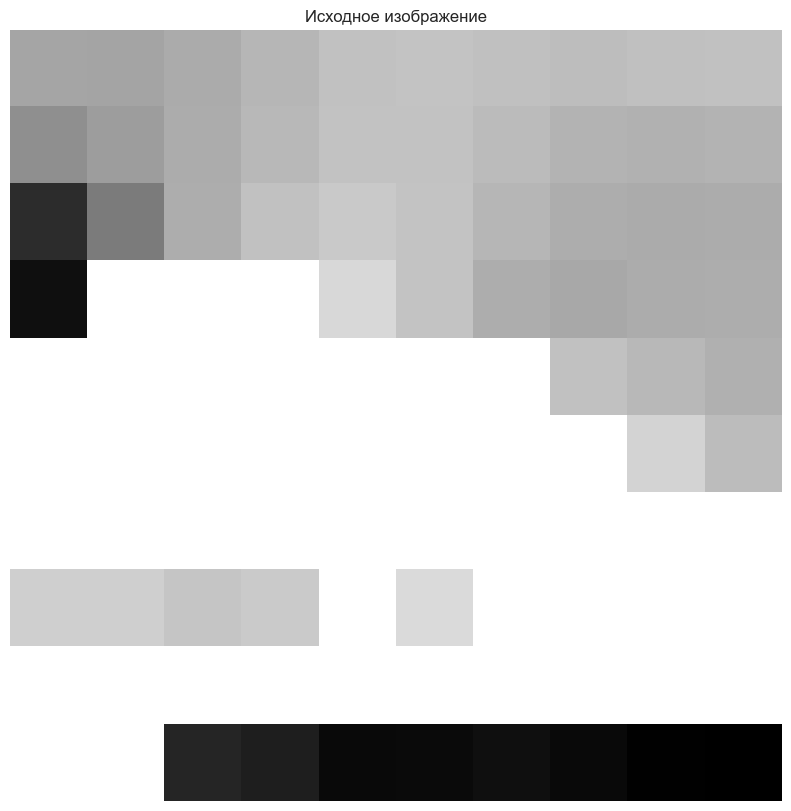

----------------
417 1050
[[120.46257  117.325134 111.805855 107.35728    0.         0.
    0.         0.         0.         0.      ]
 [120.721344 119.49337  118.51102  117.37888  116.56711  113.20281
    0.         0.         0.         0.      ]
 [120.74658  119.74294  118.72562  119.10369  118.810165 114.96617
  111.805855 109.44412    0.         0.      ]
 [116.56711  117.325134 118.465    117.92411  116.9895   116.344376
  117.109604 116.17772  113.80995  108.438675]
 [ 98.12948  106.26291  111.12914  113.408844 114.25772  115.28088
  116.76585  117.62685  118.178795 117.37888 ]
 [ 98.12948   93.81339   95.43953  100.619675 105.94794  110.82529
  114.62717  117.96758  119.6366   119.74294 ]
 [ 84.806366  90.        90.        93.81339   96.008194  97.852646
  109.183014 116.56711  118.651405 118.71458 ]
 [  0.         0.         0.         0.         0.        90.
   95.193634 111.37506  116.56711  117.18251 ]
 [  0.         0.         0.         0.         0.         0.
    0.  

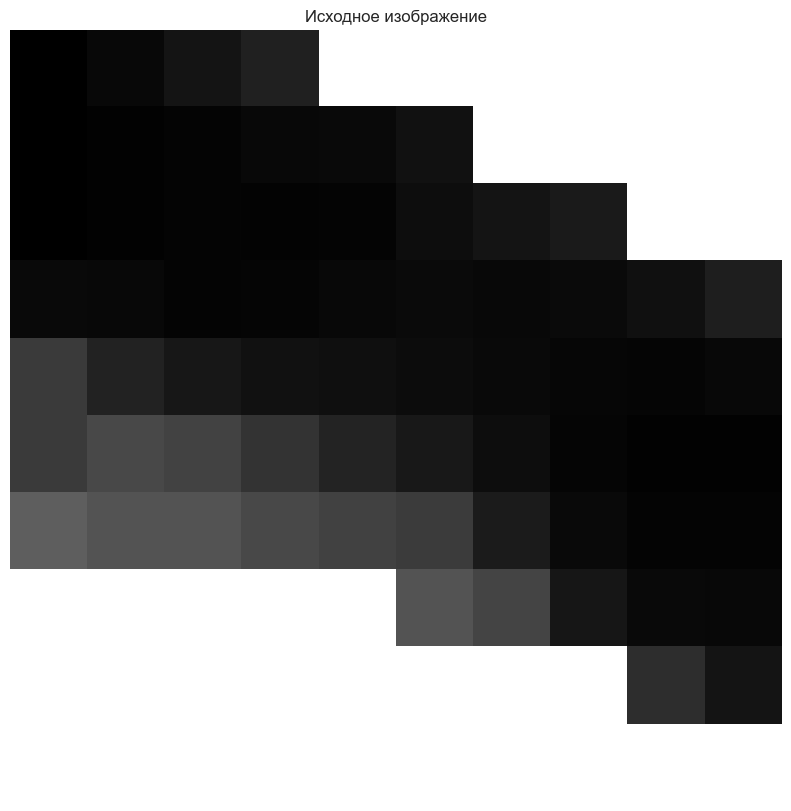

----------------
700 1050
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


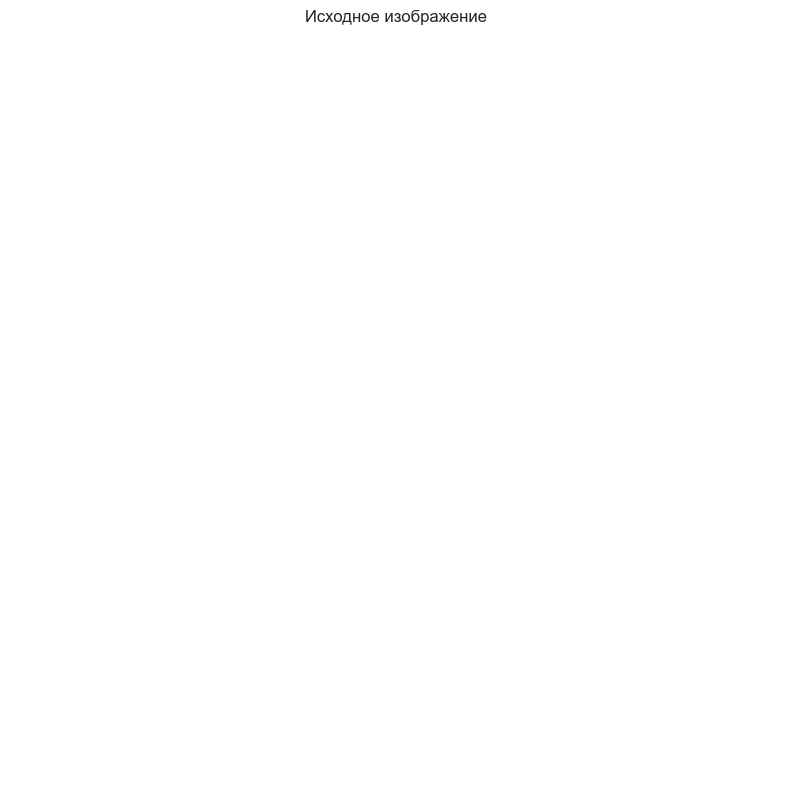

----------------
466 699
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


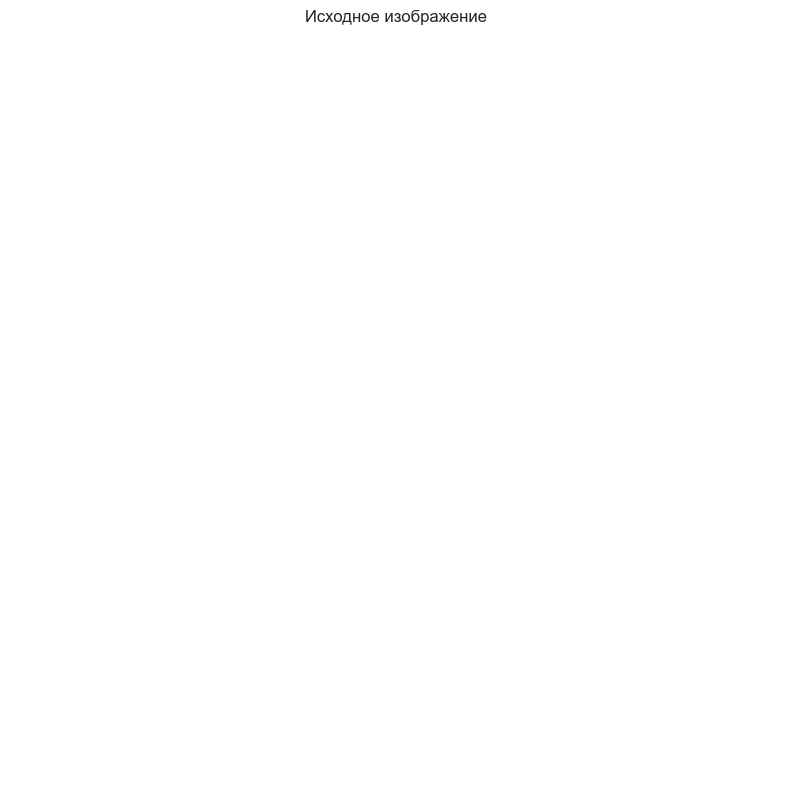

----------------
618 1050
[[185.70978  187.12427  195.2573     0.         0.         0.
    0.         0.       326.3168   326.3168  ]
 [199.98735  183.57568  169.69524    0.         0.         0.
    0.         0.         0.       344.05206 ]
 [217.87064  191.31021  150.25706    0.         0.         0.
    0.         0.         0.         0.      ]
 [203.20282    0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [171.87051    0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [180.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [123.683205 156.79718  171.87051    0.         0.         0.
    0.         0.         0.         0. 

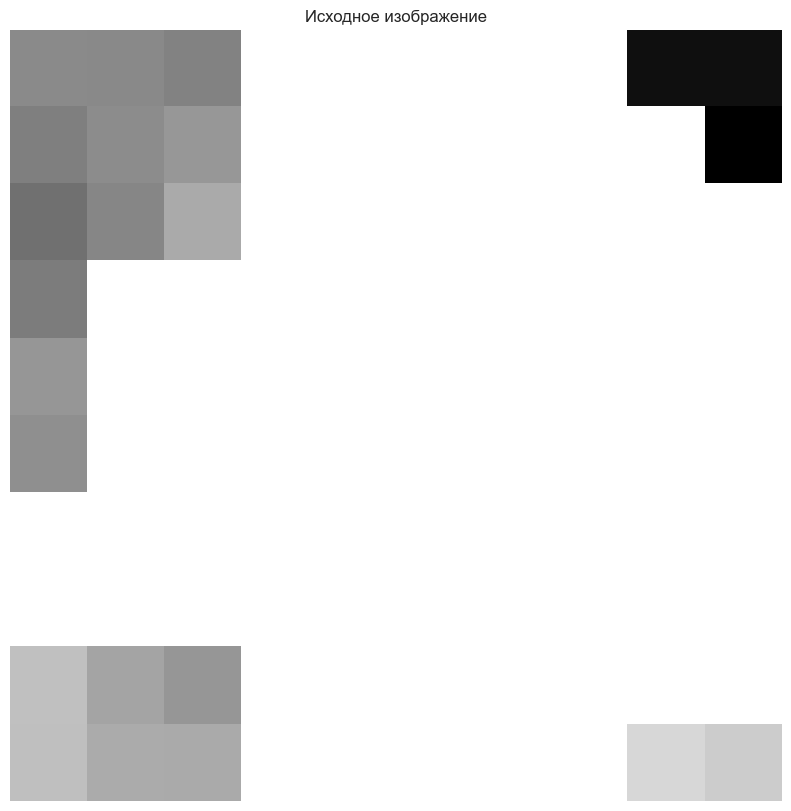

----------------
700 1050
[[  0.         0.         0.         0.         0.         0.
   63.432896  66.79719   60.257057   0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.       278.1295   276.3394  ]
 [280.6197   276.70905  273.17923  273.0122   272.86185  275.4395
  275.70978  270.       267.39795  270.      ]
 [272.29016  272.12067  270.       270.       270.       273.8134
  275.70978  270.       266.0555   268.09125 ]
 [270.       270.       267.70984  265.76434  270.       274.0849
  273.9445   271.97455  267.95502  267.87933 ]
 [265.9151   266.1866   259.9922   259.9922   266.63416  273.17923
  276.3394   273.0122   270.       270.      ]
 [246.79718  251.56133  251.56133  255.96222  261.8705     0.
  278.1295   270.       270.       270.      ]
 [219.80698  243.43289    0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.      

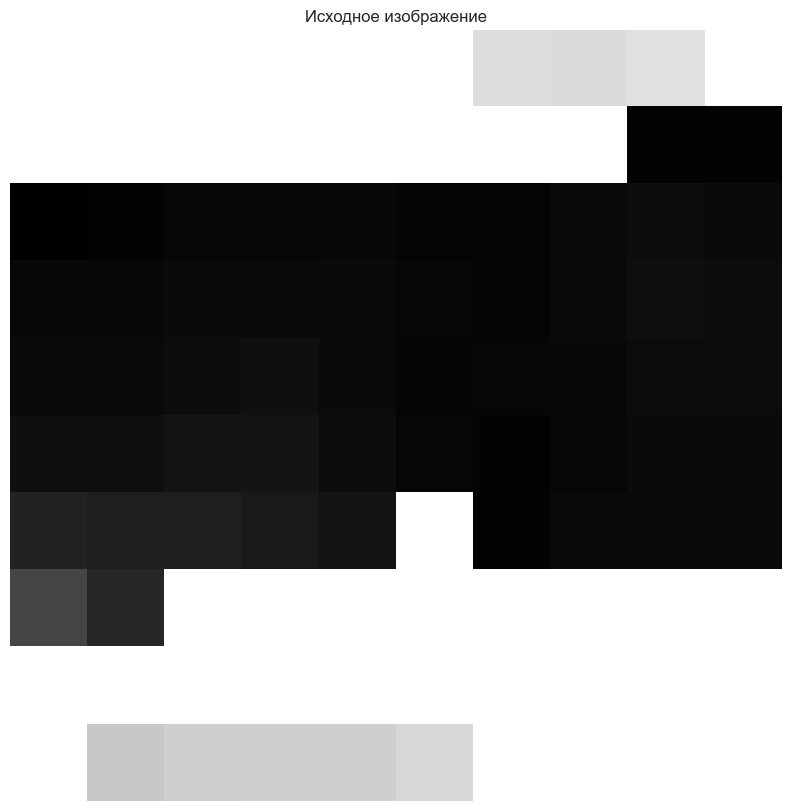

----------------
667 1000
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


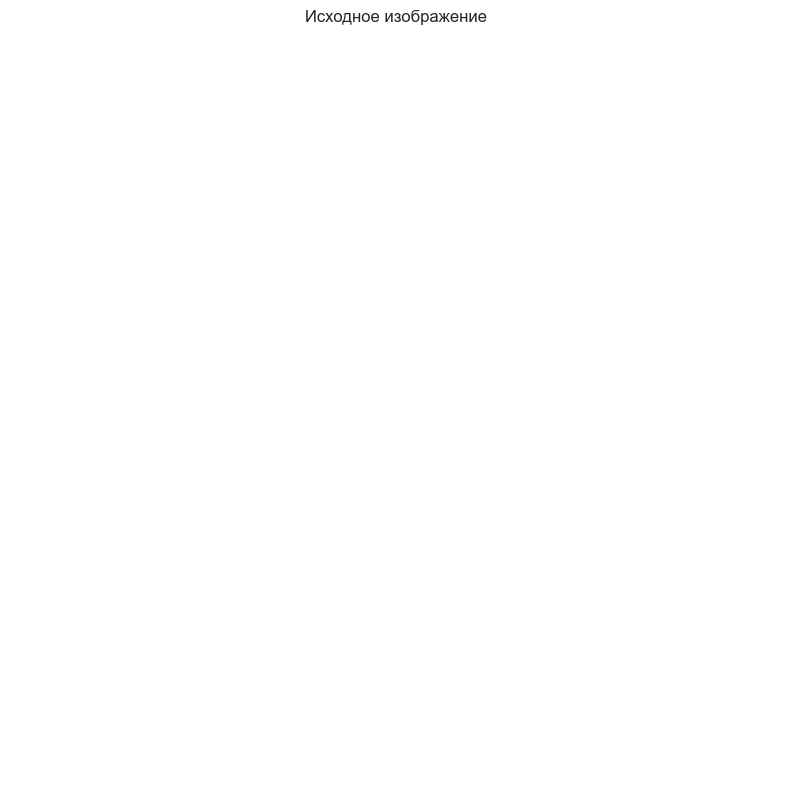

----------------
500 700
[[123.683205 123.683205   0.         0.         0.         0.
    0.         0.         0.       154.97975 ]
 [118.6101   124.68779  145.01538    0.         0.         0.
    0.         0.         0.       180.      ]
 [  0.       149.74625  163.6077   180.         0.         0.
    0.         0.         0.       209.05363 ]
 [  0.       185.70978  160.55588  142.4364     0.         0.
    0.         0.         0.         0.      ]
 [281.3102     0.       126.863716 117.89783  116.56711  135.00955
  161.56133    0.         0.         0.      ]
 [  0.         0.        68.194145 108.438675 126.24695  142.4364
  137.7175   111.805855  84.806366  85.60204 ]
 [ 41.6411    39.80698   55.015377 113.96643  145.31221  150.25706
  131.99557   99.46198   74.05206   75.96222 ]
 [ 49.760693  44.990456   0.         0.       149.74625  143.13629
  124.98462   90.        65.552345  65.552345]
 [ 55.015377   0.         0.         0.       145.01538  137.7175
  122.465515  94.7

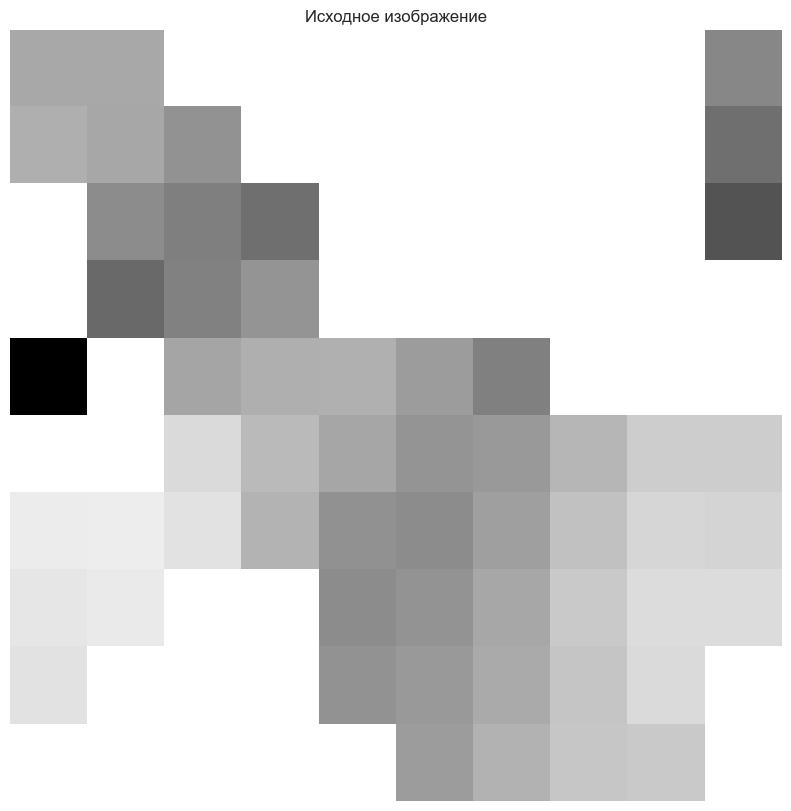

----------------
599 1050
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


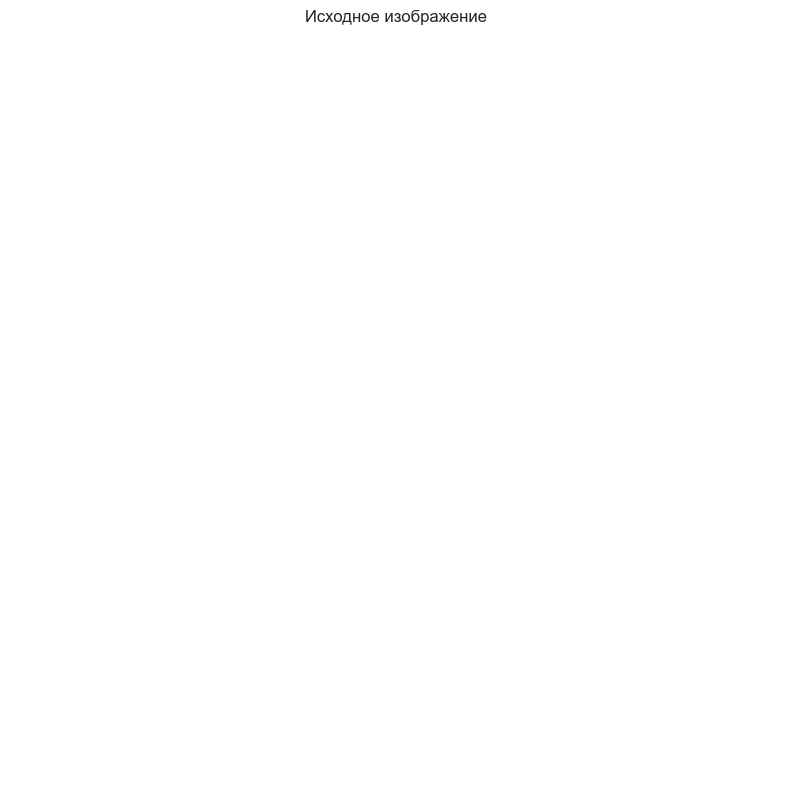

----------------
1032 1050
[[140.19302  129.80698  119.74294    0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.       116.56711  113.96643  110.5604     0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.       119.74294  135.00955  156.79718  164.05206
  180.         0.         0.         0.      ]
 [  0.         0.         0.       156.79718  165.96222  165.96222
  165.96222    0.         0.         0.      ]
 [  0.         0.         0.         0.       159.4396   150.25706
  144.46964  135.00955    0.        39.80698 ]
 [  0.         0.         0.         0.         0.       140.19302
  135.00955  113.96643   90.        71.561325]
 [  0.         0.         0.         0.         0.         0.
    0.       102.5296    90.        83.66061 ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.        90.        90.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.  

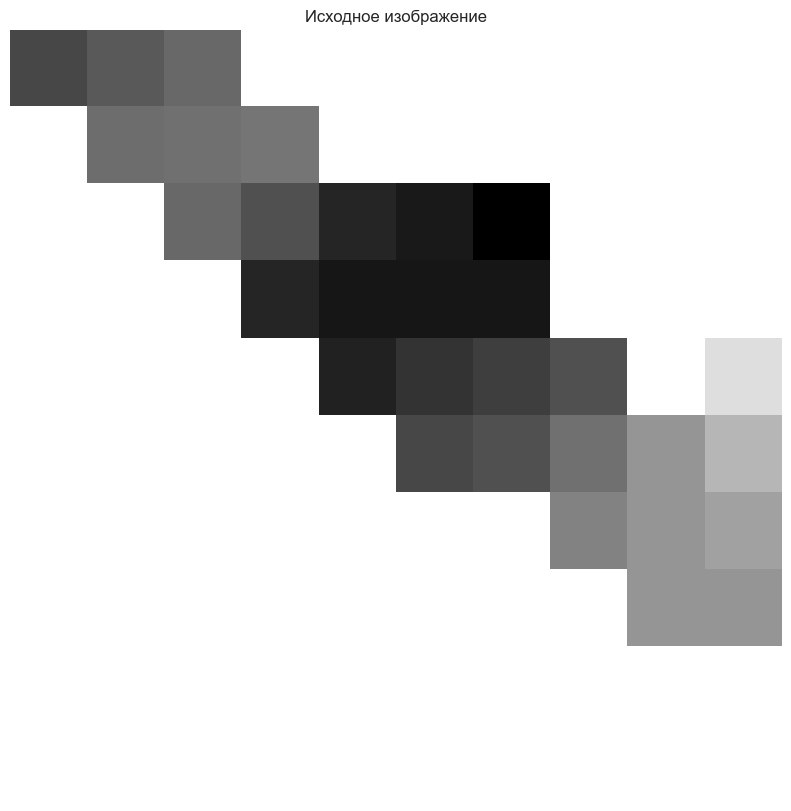

----------------
500 700
[[ 71.561325  90.       116.56711  140.19302  171.87051  285.94794
  318.00443  328.3971   315.00955    0.      ]
 [ 68.194145  96.33939  143.97969  160.55588  160.34203    0.
  352.87573  342.89413  320.19302    0.      ]
 [  0.         0.       155.55234  154.97975  135.00955  107.10586
   68.194145  23.966429   0.         0.      ]
 [  0.         0.       138.80783  135.00955  119.74294  109.657974
   94.39796   71.561325   0.         0.      ]
 [347.4704     0.         0.       135.00955  126.02031  114.447655
   95.193634  97.12427    0.         0.      ]
 [356.1866    18.438679   0.         0.       129.80698  112.62422
  107.10586  123.683205 156.03357    0.      ]
 [  0.         0.         0.         0.         0.        77.4704
  105.94794  127.56359  137.48053  131.6411  ]
 [337.61548  298.6101   251.56133  252.89413  298.6101   336.03357
    0.       126.863716 135.00955  144.46964 ]
 [297.64685  274.39795  261.25433  262.2355   296.5671   320.19302


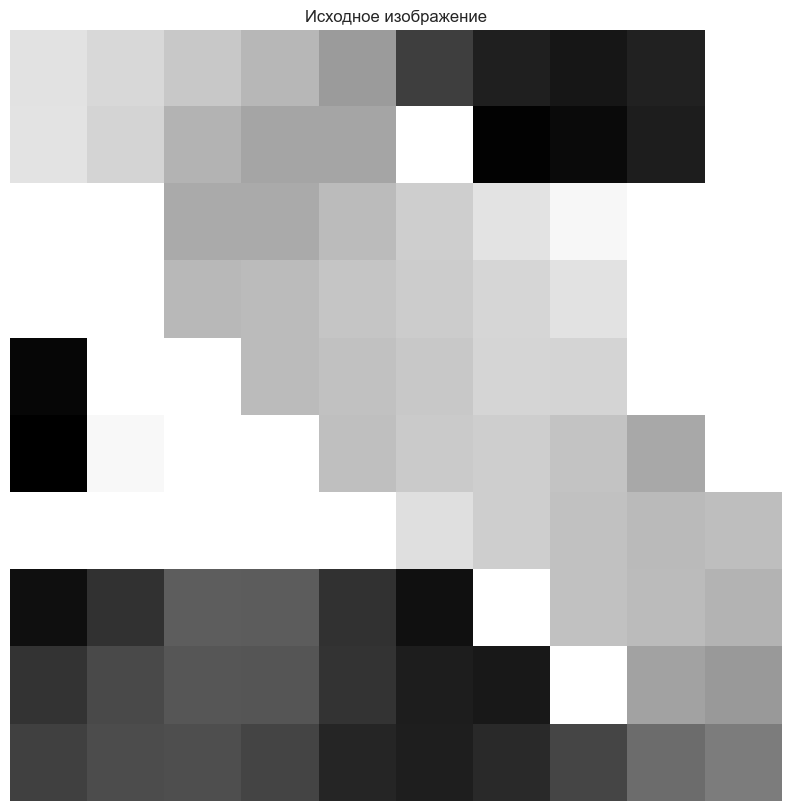

----------------


In [517]:
for i in range(0, 10):
    if i == 4 or i == 5:
        continue
    image = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
    go(image)
    print("----------------")
for i in range(10, 13):
    image = cv2.imread(f'whale_tail/test_image_{i}.jpg')
    go(image)
    print("----------------")

In [376]:
image = cv2.imread('whale_tail/test_image_02.jpg')
h, w, _ = image.shape
image = cv2.resize(image.copy(), (w // 2, h // 2))
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
print(h, w)
# grayscale
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

700 1050


(Text(0.5, 1.0, 'Исходное изображение'), (-0.5, 524.5, 349.5, -0.5))

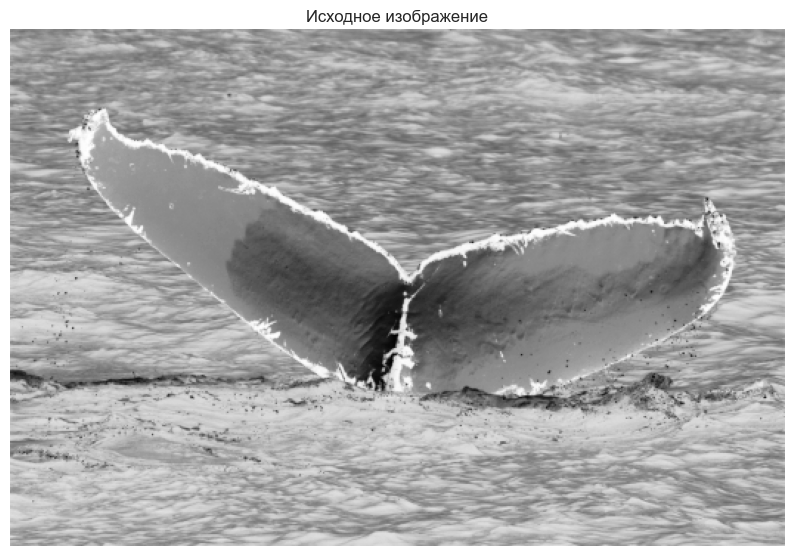

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(gray)
plt.title('Исходное изображение'), plt.axis('off')

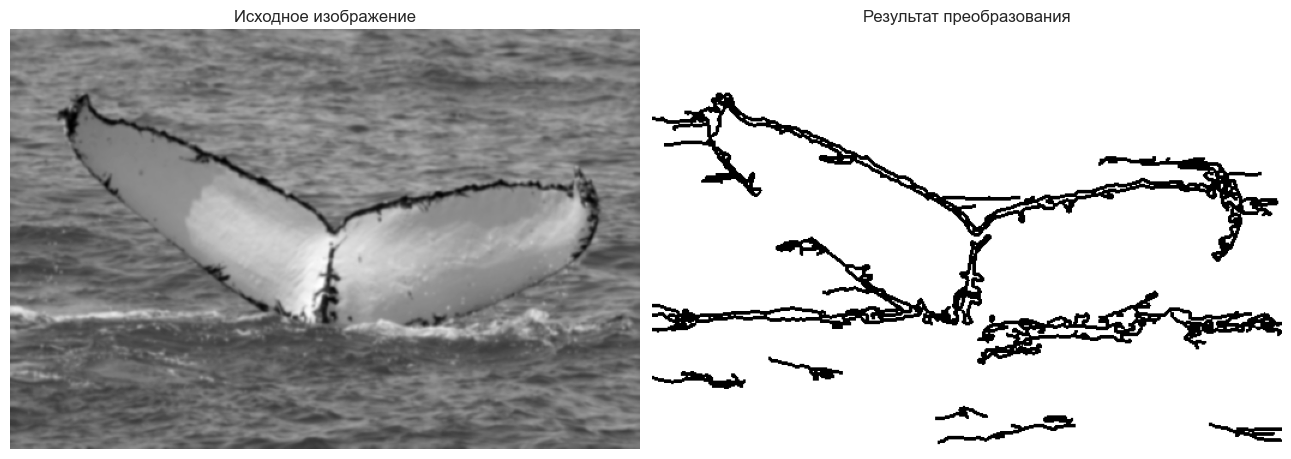

In [70]:
contours(image, 5, 10, 250, 3, False)

In [111]:
def go(image):
    h, w, _ = image.shape
    image = cv2.resize(image.copy(), (w // 2, h // 2))
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    # print(h, w)
    # grayscale
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    contours(image, 5, 10, 60, 3, True)

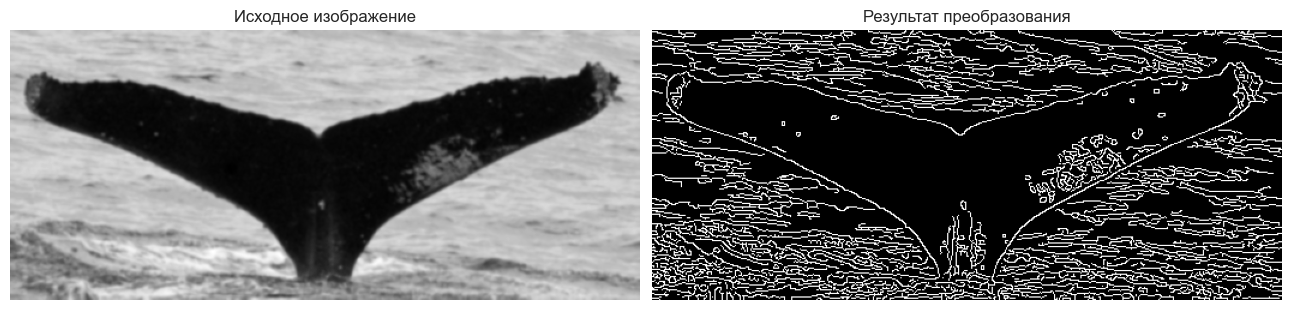

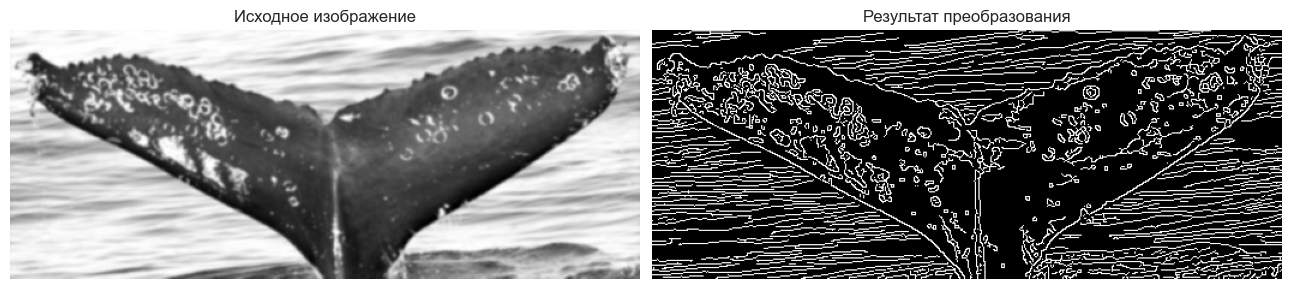

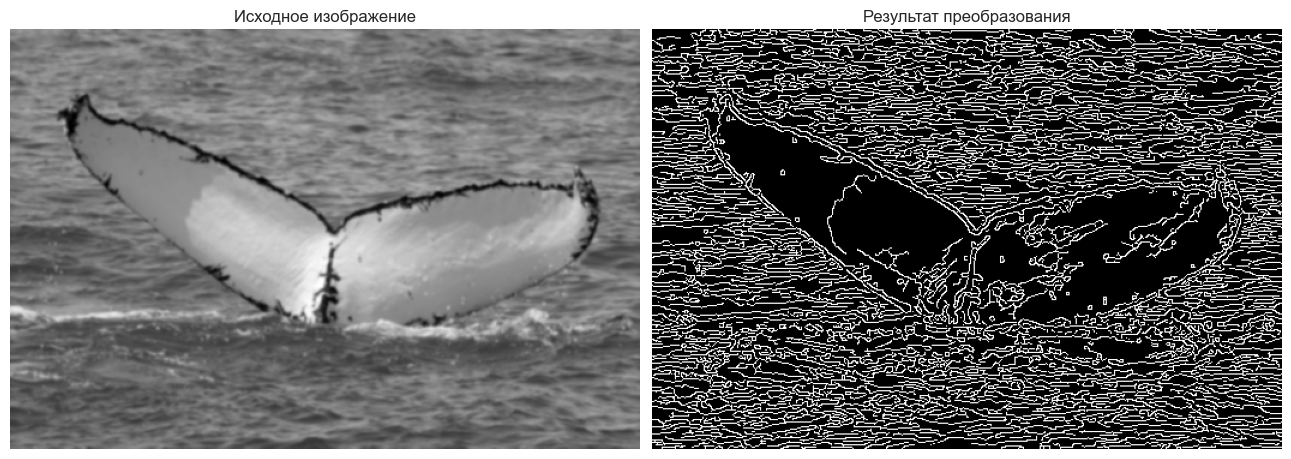

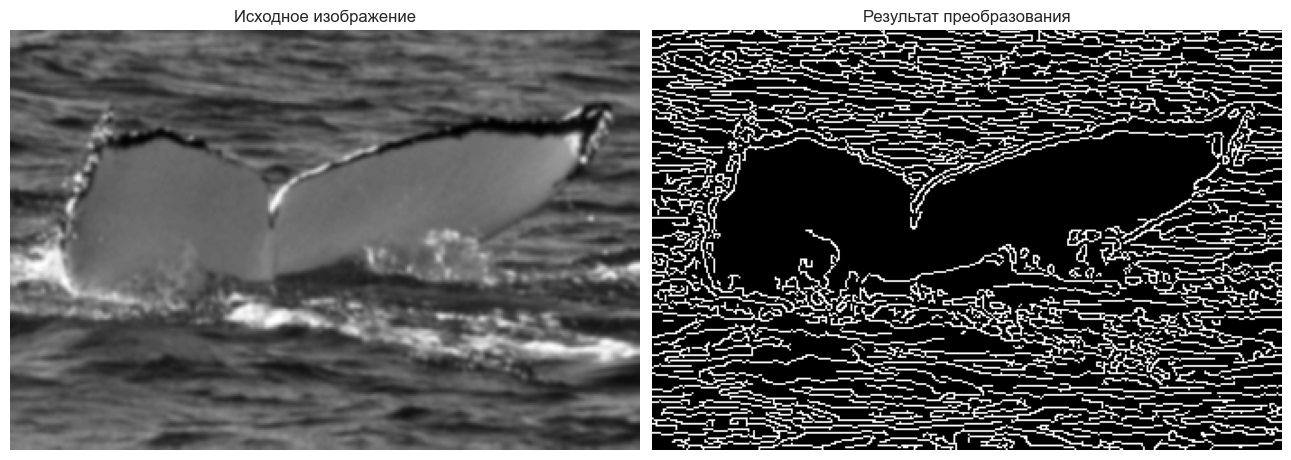

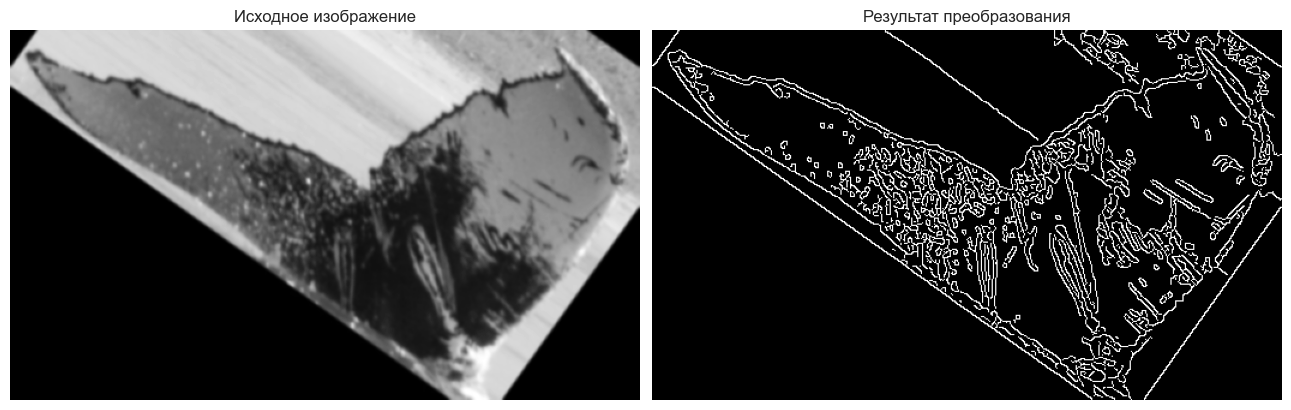

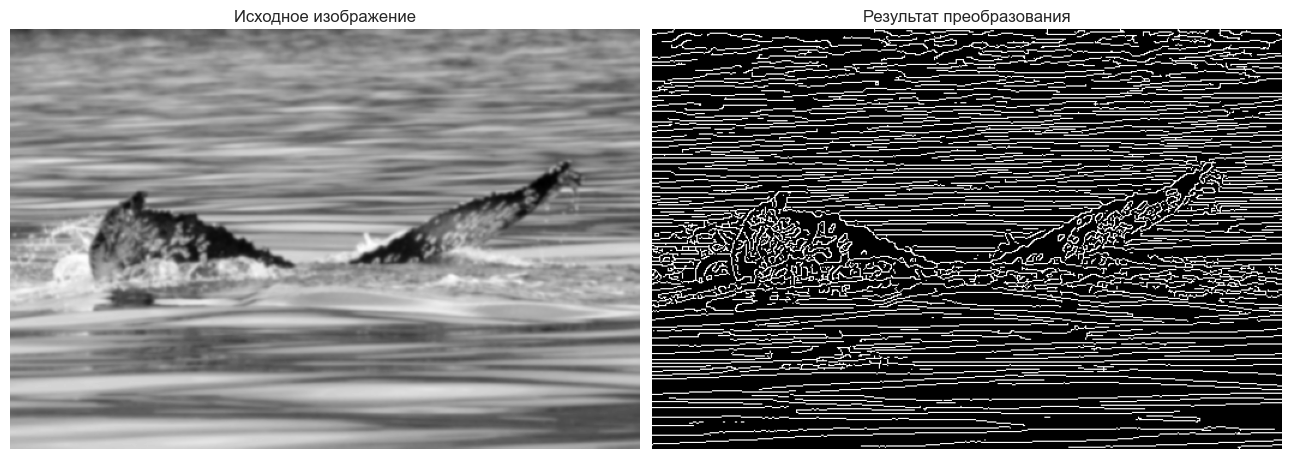

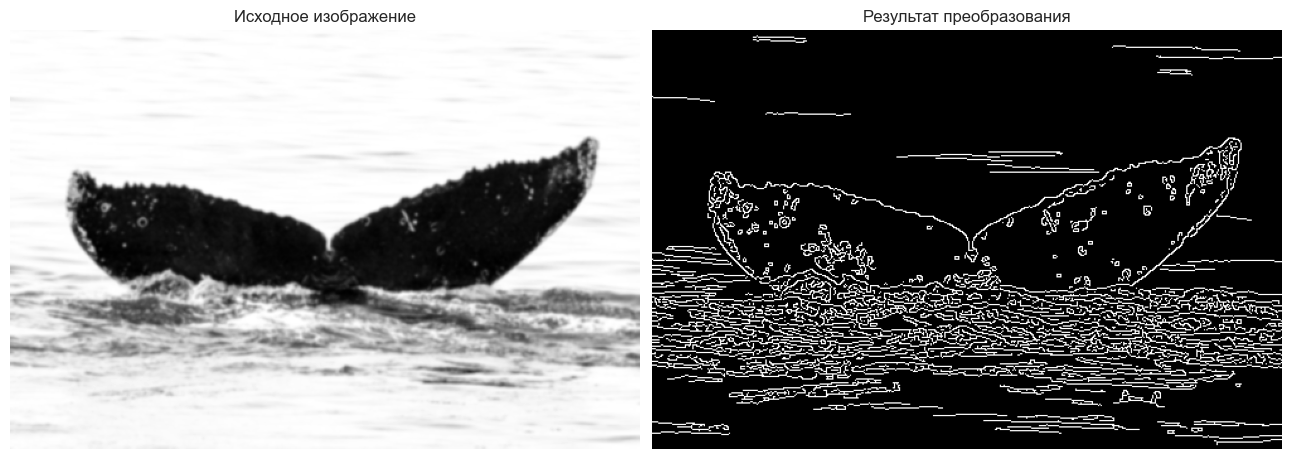

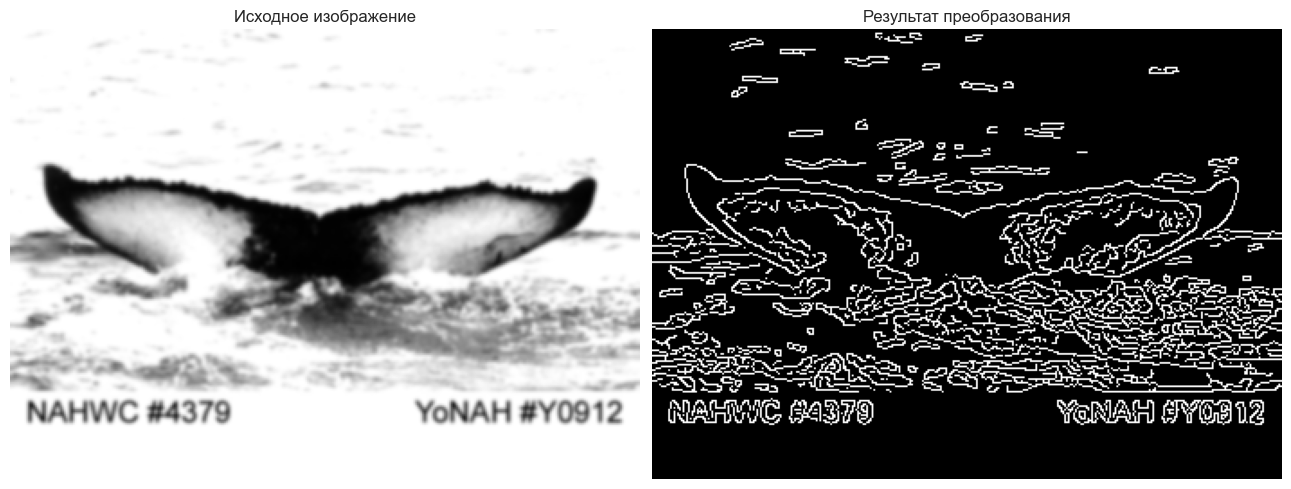

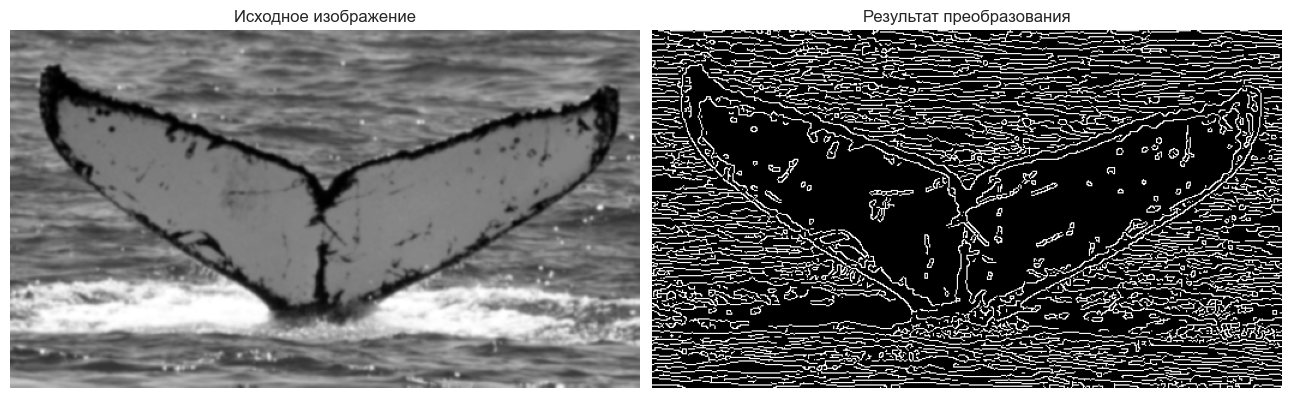

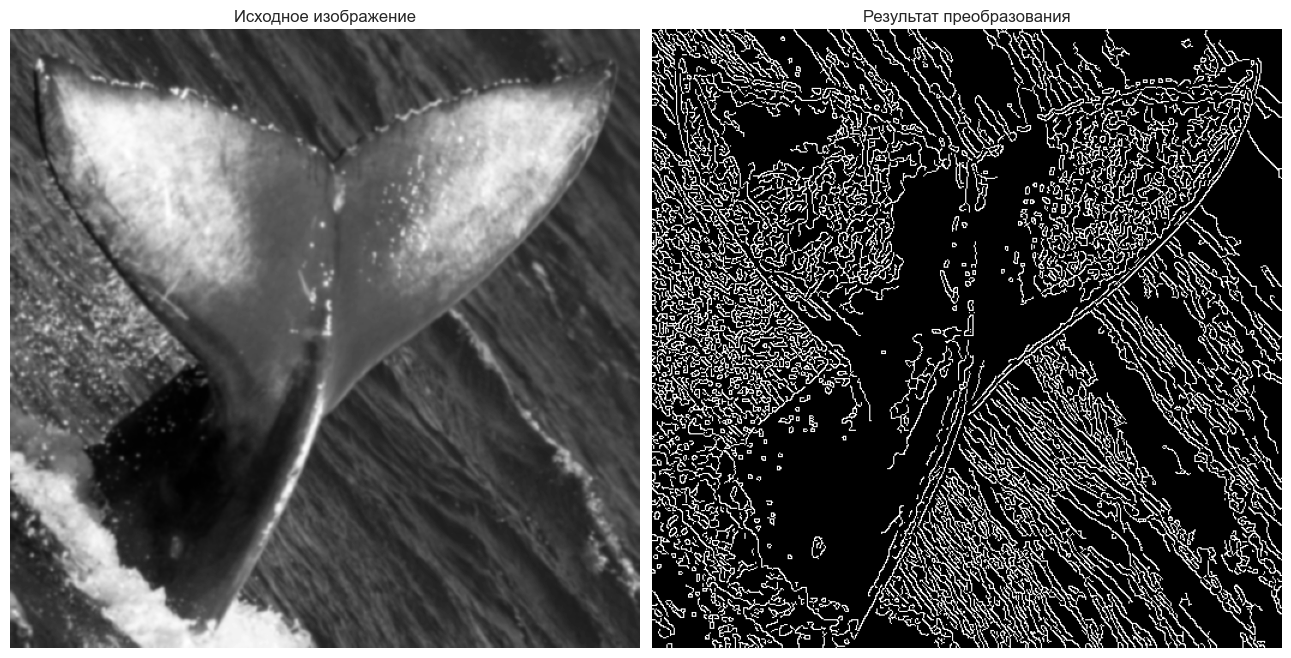

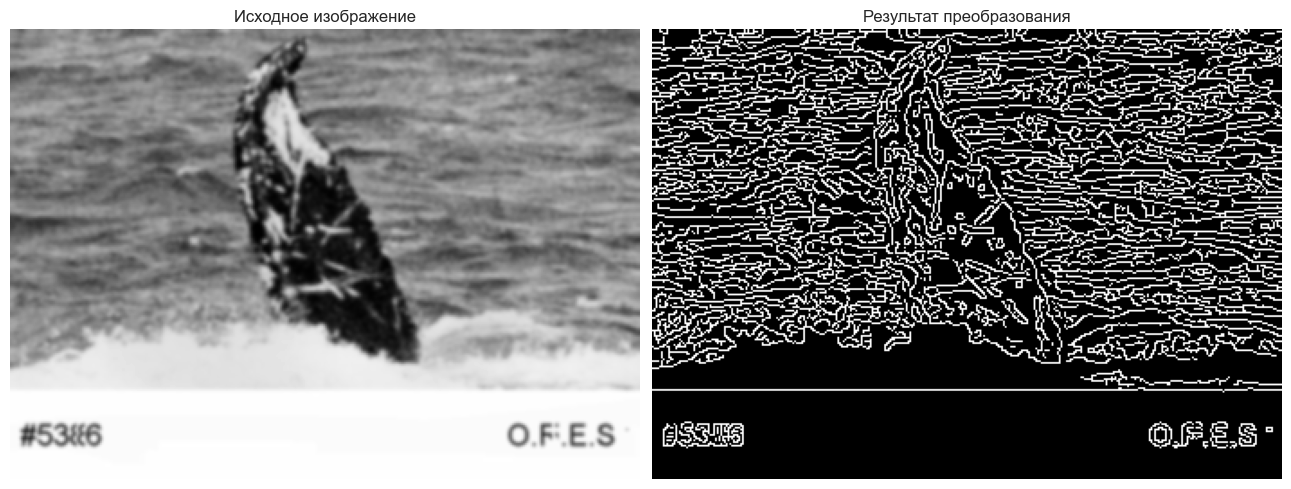

In [112]:
for i in range(10):
    if i == 4 or i == 5:
        continue
    image = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
    go(image)
for i in range(10, 13):
    image = cv2.imread(f'whale_tail/test_image_{i}.jpg')
    go(image)

In [1081]:
kernel = np.ones([5,5])/16
kernel[1:4, 1:4] = 0
kernel

array([[0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.    , 0.    , 0.    , 0.0625],
       [0.0625, 0.    , 0.    , 0.    , 0.0625],
       [0.0625, 0.    , 0.    , 0.    , 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625, 0.0625]])